In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
# Read in the data from Excel file
bean_data_file = "./DryBeanDataset/Dry_Bean_Dataset.xlsx"
beans = pd.read_excel(bean_data_file)
# Labels are characters but should be integers for sklearn
le = LabelEncoder()
beans["Class"] = le.fit_transform(beans["Class"])
# Split data into classification target and features
y = beans["Class"]
X = beans.drop("Class", axis = 1)
# Split of training data
X_train, X_rest1, y_train, y_rest1 = train_test_split(
X, y, train_size=10000, random_state=2
)
# From the remaining data, split of test data
X_test, X_rest2, y_test, y_rest2 = train_test_split(
X_rest1, y_rest1, train_size=1000, random_state=42)

X_calib, X_new, y_calib, y_new = train_test_split(
X_rest2, y_rest2, train_size=1000, random_state=42
)
# Fit the model
model = GaussianNB().fit(X_train, y_train)

In [5]:
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score
from mapie.metrics import classification_mean_width_score

- Naive method
  - Assume the probabilities are well calibrated
- Score method
  - Simple, but not adaptative to the difficulty of each level of classification
  - Depending on the level of difficulty of a class, the $1-\alpha$ threshold might be different for each class

- Conditional coverage
  - Coverage guarantee for groups of the data

In [6]:
mapie_score = MapieClassifier(model, cv="prefit", method="naive")
# Calibration step
mapie_score.fit(X_train, y_train) # Naive doesnt need calibration step, so this makes no diference
y_pred, y_set = mapie_score.predict(X_new, alpha=0.05)
# Removing the alpha-dimension
y_set = np.squeeze(y_set)

In [7]:
cov = classification_coverage_score(y_new, y_set)
setsize = classification_mean_width_score(y_set)
print('Coverage: {:.2%}'.format(cov))
print('Avg. set size: {:.2f}'.format(setsize))

Coverage: 90.32%
Avg. set size: 1.41


In [8]:
mapie_score = MapieClassifier(model, cv='prefit', method='score')
mapie_score.fit(X_calib, y_calib)
y_pred, y_set = mapie_score.predict(X_new, alpha=0.05)
y_set = np.squeeze(y_set)

In [9]:
cov = classification_coverage_score(y_new, y_set)
setsize = classification_mean_width_score(y_set)
print('Coverage: {:.2%}'.format(cov))
print("Avg. set size: {:.2f}".format(setsize))


Coverage: 96.28%
Avg. set size: 1.83


In [12]:
def class_wise_performance(y_new, y_set, classes):
    df = pd.DataFrame()
    # Loop through the classes
    for i in range(len(classes)):
    # Calculate the coverage and set size for the current class
        ynew = y_new.values[y_new.values == i]
        yscore = y_set[y_new.values == i]
        cov = classification_coverage_score(ynew, yscore)
        size = classification_mean_width_score(yscore)
        # Create a new dataframe with the calculated values
        temp_df = pd.DataFrame({
        "class": [classes[i]],
        "coverage": [cov],
        "avg. set size": [size]
        }, index = [i])
        # Concatenate the new dataframe with the existing one
        df = pd.concat([df, temp_df])
    return(df)
print(class_wise_performance(y_new, y_set, le.classes_))


      class  coverage  avg. set size
0  BARBUNYA  0.925287       2.137931
1    BOMBAY  1.000000       1.000000
2      CALI  0.965909       2.130682
3  DERMASON  0.972906       1.463054
4     HOROZ  0.938525       1.872951
5     SEKER  0.970213       2.017021
6      SIRA  0.974277       1.974277


- Adaptative Prediction Sets
  - A conformal prediction algorithm is adaptative if it reaches marginal and conditional coverage
  - APS Algorithm
    - Adds up probabilities (starting with the largest up to the true class) -> Non conformative score
    - Calibration
      - Computes all cumulative scores $s_{i}$
      - Compute the quantile level correct to finite sample size
      - Compute the qlevel quantile for the calibration data so that $1-\alpha$ are below the threshold
    - Prediction
      - Compute all classes probabilities for new point $x$
      - Sort the classes in descending order
      - Include all classes until the threshold is reached
      - Three options
        - Include the label above the threshold
        - Don't include it
        - Include the label at random

In [13]:
mapie_score = MapieClassifier(model, cv="prefit",
method="cumulated_score",
random_state=1)
mapie_score.fit(X_calib, y_calib)


MapieClassifier(cv='prefit', estimator=GaussianNB(), method='cumulated_score',
                random_state=1)

In [15]:
y_pred, y_set = mapie_score.predict(X_new, alpha=0.05,
include_last_label=True)
y_set = np.squeeze(y_set)
cov = classification_coverage_score(y_new, y_set)
setsize = classification_mean_width_score(y_set)
print('Coverage: {:.2%}'.format(cov))
print("Avg. set size: {:.2f}".format(setsize))
print(class_wise_performance(y_new, y_set, le.classes_))

Coverage: 96.96%
Avg. set size: 1.91
      class  coverage  avg. set size
0  BARBUNYA  0.931034       2.206897
1    BOMBAY  1.000000       1.000000
2      CALI  0.971591       2.153409
3  DERMASON  0.982759       1.512315
4     HOROZ  0.946721       1.979508
5     SEKER  0.982979       2.114894
6      SIRA  0.974277       2.131833


In [16]:
y_pred, y_set = mapie_score.predict(X_new, alpha=0.05,
include_last_label=False)
y_set = np.squeeze(y_set)
cov = classification_coverage_score(y_new, y_set)
setsize = classification_mean_width_score(y_set)
print('Coverage: {:.2%}'.format(cov))
print("Avg. set size: {:.2f}".format(setsize))
print(class_wise_performance(y_new, y_set, le.classes_))


Coverage: 81.50%
Avg. set size: 1.18
      class  coverage  avg. set size
0  BARBUNYA  0.534483       1.218391
1    BOMBAY  1.000000       1.000000
2      CALI  0.846591       1.153409
3  DERMASON  0.921182       1.162562
4     HOROZ  0.803279       1.274590
5     SEKER  0.731915       1.131915
6      SIRA  0.848875       1.170418


In [18]:
y_pred, y_set = mapie_score.predict(X_new, alpha=0.05,
include_last_label="randomized")
y_set = np.squeeze(y_set)
cov = classification_coverage_score(y_new, y_set)
setsize = classification_mean_width_score(y_set)
print('Coverage: {:.2%}'.format(cov))
print("Avg. set size: {:.2f}".format(setsize))
print(class_wise_performance(y_new, y_set, le.classes_))

Coverage: 95.97%
Avg. set size: 1.89
      class  coverage  avg. set size
0  BARBUNYA  0.931034       2.212644
1    BOMBAY  1.000000       2.000000
2      CALI  0.960227       2.164773
3  DERMASON  0.972906       1.443350
4     HOROZ  0.934426       1.979508
5     SEKER  0.961702       1.978723
6      SIRA  0.967846       1.980707


- Top-k method for fixed size sets
  - Top-k uses only the rank of the true class instead of the probability outcome
  - The higher the rank, the less certain the model is in predicting the class
  - Produces fixed size sets
  - Worst adaptativity of all 

In [19]:
mapie_score = MapieClassifier(model, cv="prefit", method="top_k")
mapie_score.fit(X_calib, y_calib)
y_pred, y_set = mapie_score.predict(X_new, alpha=0.05)
y_set = np.squeeze(y_set)
cov = classification_coverage_score(y_new, y_set)
setsize = classification_mean_width_score(y_set)
print('Coverage: {:.2%}'.format(cov))
print("Avg. set size: {:.2f}".format(setsize))
print(class_wise_performance(y_new, y_set, le.classes_))

Coverage: 98.82%
Avg. set size: 3.61
      class  coverage  avg. set size
0  BARBUNYA  0.971264       3.413793
1    BOMBAY  1.000000       7.000000
2      CALI  0.982955       3.750000
3  DERMASON  0.997537       4.261084
4     HOROZ  0.971311       3.000000
5     SEKER  0.987234       3.000000
6      SIRA  1.000000       3.000000


- Regularized APS
  - RAPS tries to fix APS introducing regularization
  - Two parameters -> $\lambda$ and $k_{reg}$
  - Algorithm
    - Class probabilities sorted in descending order
    - All classes with rank higher than $k_{reg}$ receive a penalty
    - This penalty depends on $\lambda$ and how many classes away the true label is from $k_{reg}$
    - The penalty is added to the class probability
  - Apart from the regularization part, the procedure is the same as the APS
  - Effect of the penalty
    - Classes with low probabilities are less likely to be included
  - Have to sacrifice some part of the calibration data to tune the regularization

In [21]:
mapie_score = MapieClassifier(model, cv="prefit", method="raps")
mapie_score.fit(X_calib, y_calib, size_raps=0.2)
y_pred, y_set = mapie_score.predict(X_new, alpha=0.05,
include_last_label="randomized")
y_set = np.squeeze(y_set)
cov = classification_coverage_score(y_new, y_set)
setsize = classification_mean_width_score(y_set)
print('Coverage: {:.2%}'.format(cov))
print("Avg. set size: {:.2f}".format(setsize))
print(class_wise_performance(y_new, y_set, le.classes_))
# RAPS is more useful with many classes, such as image net

Coverage: 95.84%
Avg. set size: 1.86
      class  coverage  avg. set size
0  BARBUNYA  0.925287       2.149425
1    BOMBAY  1.000000       2.000000
2      CALI  0.948864       2.102273
3  DERMASON  0.970443       1.460591
4     HOROZ  0.934426       1.844262
5     SEKER  0.974468       2.008511
6      SIRA  0.964630       1.964630


- Group-balanced conformal prediction
  - APS and RAPS doesnt no guarantee coverage for every group of data points
  - Performs conformal prediction for each group, so it wont work if we split by class
  - Ends up with really small sets for each group

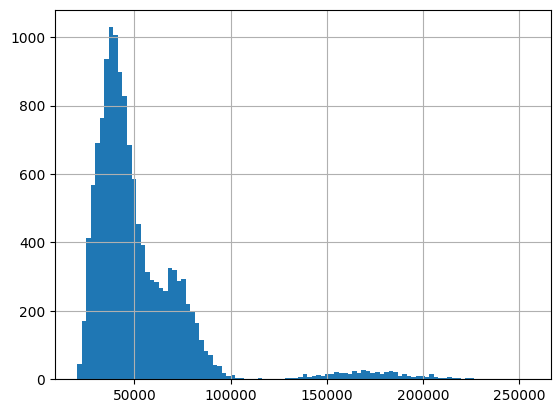

In [22]:
X.Area.hist(bins = 100)
small_bean_index = X_calib.Area < 70000

In [23]:
X_calib_group = X_calib[small_bean_index]
y_calib_group = y_calib[small_bean_index]
mapie_group = MapieClassifier(model, cv="prefit", method="score")
mapie_group.fit(X_calib_group, y_calib_group.values)

C:\Users\Gabriel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\mapie\classification.py:1031: UserWarning: WARNING: your calibration dataset has less labels than your training dataset (training has 7 unique labels while calibration have 6 unique labels
  warnings.warn(


MapieClassifier(cv='prefit', estimator=GaussianNB(), method='score')

In [24]:
group_index = X_new.Area < 70000
X_group = X_new[group_index]
y_pred, y_set = mapie_group.predict(X_group, alpha=0.05)

- Class-Conditional APS (CCAPS) for coverage by class
  - Performed the same way as group balanced conformal prediction, but using class as grouping variable
  - Apply all resulting classwise conformal predictors and the prediction set is the union of all conformal classes